# Financial Planning and Analysis Workflow

## Summary
This notebook illustrates an end-to-end demand FP&A workflow in DataRobot. Time series forecasting in DataRobot has a huge suite of tools and approaches to handle highly complex multiseries problems. 

DataRobot will be used for the model training, selection, deployment, and creating forecasts. While this example will leverage a snapshot file as a datasource this workflow applies to any data source, e.g. Redshift, S3, Big Query, Synapse, etc. 


This notebook will demonstrate how to use the Python API client to:

1.  Connect to DataRobot
2.  Import and preparation of data for time series modeling
3.  Create a time series forecasting project and run Autopilot
4.  Retrieve and evaluate model performance and insights
5.  Making forward looking forecasts
6.  Evaluating forecasts vs. historical trends
7.  Deploy a model

## Setup - Import libraries

In [40]:
from datetime import datetime as dt
from platform import python_version

import datarobot as dr
from datarobot.models.data_engine_query_generator import (
    QueryGeneratorDataset,
    QueryGeneratorSettings,
)
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

print("Python version:", python_version())
print("Client version:", dr.__version__)

Python version: 3.8.8
Client version: 3.3.1


## Connect to DataRobot
To connect to DataRobot, you need to provide your API token and the endpoint. For more information, please refer to the following documentation:

 - [Create and manage API keys via developer tools in the GUI](https://docs.datarobot.com/en/docs/platform/account-mgmt/acct-settings/api-key-mgmt.html#api-key-management)
 - [Different options to connect to DataRobot from the API client](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html)
   
Your API token can be found in the DataRobot UI in the Developer tools section, accessed from the profile menu in the top right corner. Copy the API token and paste in the cell below.

In [4]:
# Instantiate the DataRobot connection

# Get the token from the Developer Tools page in the DataRobot UI
DATAROBOT_API_TOKEN = (
    "NjU5Yzg2MDFhZGJiODRkMWI3YjEyNDY3OjJUNCtPK21teE9ZL2s2eExSRk5vTG5pK1RGR01NYzZUTit3V1ZLNTBBTlk9"
)

# Endpoint - This notebook uses the default endpoint for DataRobot Managed AI Cloud (US)
DATAROBOT_ENDPOINT = (
    "https://app.datarobot.com/api/v2"  # This should be the URL you use to access the DataRobot UI
)

dr.Client(token=DATAROBOT_API_TOKEN, endpoint=DATAROBOT_ENDPOINT)

## Import Data

We will be importing 4 years of raw transactional sales data and then wrangling that data, for each product segment, into a time series format for modeling


In [5]:
# Read in csv file to dataframe
df = pd.read_csv("storage/sales.csv")

# Convert 'Order Date' columns to datetime format
df["Order Date"] = pd.to_datetime(df["Order Date"])

# Display first few rows of data
df.head()

,Order ID,Order Date,Segment,Sales,Quantity,Discount,Region
0,DE-163398,2021-11-09,Segment A,235.76400,2,0.00,South
1,DE-152520,2021-11-09,Segment A,658.74600,3,0.00,South
2,DE-151015,2021-06-13,Segment B,21.93000,2,0.00,West
3,DE-140543,2020-10-11,Segment A,861.81975,5,0.45,South
4,DE-166730,2020-10-11,Segment A,20.13120,2,0.20,South


## Data Preparation
We now need to transform our transactional data into a time series dataset with evenly spaced intervals. We will leverage DataRobot's [Data Prep for Time Series](https://docs.datarobot.com/en/docs/modeling/time/ts-modeling-data/ts-data-prep.html#set-manual-options) to transform the dataset and aggregate each product segment to the monthly level.
<br/>
<br/>
Generally speaking, DataRobot's Data Prep for Time Series will aggregates the dataset to the selected time step, and, if missing rows are detected will impute the target value. Data Prep for Time Series allows you to choose aggregation methods for numeric, categorical, and text values. You can also use it to explore modeling at different time scales. The resulting dataset is then published to DataRobot's AI Catalog.

In [6]:
# Upload the dataset to the AI Catalog
dataset = dr.Dataset.upload(df)

# Rename the entry in AI Catalog
dataset.modify(name="Transactional_Sales_Data", categories=dataset.categories)

# Create a time series data prep query generator from the dataset we just uploaded to AI Catalog
query_generator_dataset = QueryGeneratorDataset(
    alias="Transactional_Sales_Data",
    dataset_id=dataset.id,
    dataset_version_id=dataset.version_id,
)

# Set the parameters for our time series Data Prep
query_generator_settings = QueryGeneratorSettings(
    datetime_partition_column="Order Date",  # Date/time feature used as the basis for partitioning
    time_unit="MONTH",  # Time unit (seconds, days, months, etc.) that comprise the time step
    time_step=1,  # Number of (time) units that comprise the time step.
    default_numeric_aggregation_method="sum",  # Aggregate the target using either mean & most recent or sum & zero
    default_categorical_aggregation_method="last",  # Aggregate categorical features using the most frequent value or the last value within the aggregation time step.
    target="Sales",  # Numeric column in the dataset to predict.
    multiseries_id_columns=[
        "Segment"
    ],  # Column containing the series identifier, which allows DataRobot to process the dataset as a separate time series.
    default_text_aggregation_method="meanLength",  # Choose ignore to skip handling of text features or aggregate by: 'concat', 'last', 'meanLength', 'mostFrequent', 'totalLength'
    start_from_series_min_datetime=True,  # Basis for the series start date, either the earliest date for each series (per series) or the earliest date found for any series (global).
    end_to_series_max_datetime=True,  # Basis for the series end date, either the last entry date for each series (per series) or the latest date found for any series (global).
)
query_generator = dr.DataEngineQueryGenerator.create(
    generator_type="TimeSeries",
    datasets=[query_generator_dataset],
    generator_settings=query_generator_settings,
)

# Prep the training dataset
training_dataset = query_generator.create_dataset()

# Rename the entry in AI Catalog
training_dataset.modify(name="ts_monthly_training", categories=training_dataset.categories)

## Exploratory Data Analysis

Let's visualize the monthly sales for each segment in order to quickly identify anomalies, evaluate patterns and seasonality, and identify anything that may warrant further expoloration.

In [42]:
# Load the dataset into a pandas dataframe
training_df = training_dataset.get_as_dataframe()

# Convert 'Order Date' to datetime format and sort
training_df["Order Date"] = pd.to_datetime(training_df["Order Date"])

# Adding Total Sales as an additional segment
total_sales = training_df.groupby("Order Date").agg({"Sales": "sum"}).reset_index()
total_sales["Segment"] = "Total"
training_df = pd.concat([training_df, total_sales], ignore_index=True)

# Visualize our data:
fig = go.Figure()

# Line chart for monthly sales by segment
fig.add_trace(
    go.Scatter(
        x=training_df[training_df["Segment"] == "Segment A"]["Order Date"],
        y=training_df[training_df["Segment"] == "Segment A"]["Sales"],
        mode="lines",
        name="Segment A",
    )
)
fig.add_trace(
    go.Scatter(
        x=training_df[training_df["Segment"] == "Segment B"]["Order Date"],
        y=training_df[training_df["Segment"] == "Segment B"]["Sales"],
        mode="lines",
        name="Segment B",
    )
)
fig.add_trace(
    go.Scatter(
        x=training_df[training_df["Segment"] == "Segment C"]["Order Date"],
        y=training_df[training_df["Segment"] == "Segment C"]["Sales"],
        mode="lines",
        name="Segment C",
    )
)
fig.add_trace(
    go.Scatter(
        x=training_df[training_df["Segment"] == "Total"]["Order Date"],
        y=training_df[training_df["Segment"] == "Total"]["Sales"],
        mode="lines",
        name="Total",
    )
)

fig.update_layout(
    title="Monthly Sales by Segment and Total",
    xaxis_title="Date",
    yaxis_title="Sales",
    template="plotly_dark",
)
fig.show()

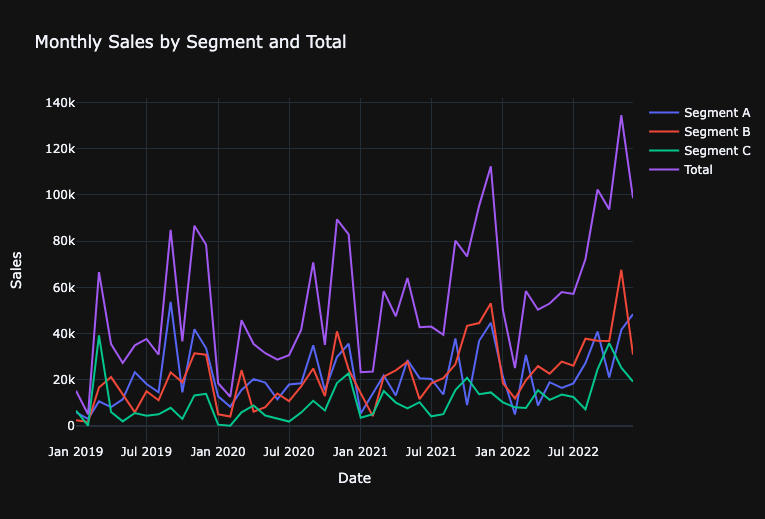

## Create a time series forecasting project and run Autopilot

We can create a project using our dataset in the AI Catalog:

In [8]:
# Create a new DataRobot project
project = dr.Project.create_from_dataset(
    project_name="Monthly_Sales_Forecast", dataset_id=training_dataset.id
)

In [9]:
# Quick link to the DataRobot project you just created
# Note: the get_uri for projects goes to the Model tab. This won't be populated yet since we haven't run Autopilot.
# Switch to the Data tab in the UI after following the url to get to the project setup section.
print("DataRobot Project URL: " + project.get_uri())
print("Project ID: " + project.id)

DataRobot Project URL: https://app.datarobot.com/projects/659c86c4f40076f93f064d79/models
Project ID: 659c86c4f40076f93f064d79


Configure time-series modeling settings
Time-series projects have a number of parameters we can adjust. This includes:

- Multi-series (i.e. Series ID column)
- Backtest partitioning
- Feature Derivation Window
- Forecast Window
- Known-in-advance (KA) Variables
- Do not derive (DND) Variables
- Calendars

In [10]:
# Set Time Series Parameters
# Feature Derivation Window
# What rolling window should DataRobot use to derive features?
FDW = [(-6, 0)]

# Forecast Window
# Which future values do you want to forecast? (i.e. Forecast Distances)
FW = [(1, 12)]

# Known In Advance features
# Features that will be known at prediction time - all other features will go through an iterative feature engineering and selection process to create time-series features.
FEATURE_SETTINGS = []
KA_VARS = []
for column in KA_VARS:
    FEATURE_SETTINGS.append(dr.FeatureSettings(column, known_in_advance=True, do_not_derive=False))

# Calendar
# Create a calendar file from a dataset to see how specific events by date contribute to better model performance
CALENDAR = dr.CalendarFile.create_calendar_from_country_code(
    country_code="US",
    start_date=min(training_df["Order Date"]),  # Earliest date in calendar
    end_date=max(training_df["Order Date"]),
)  # Last date in calendar

We pass all our settings to a [DatetimePartitioningSpecification](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/modeling/spec/datetime_partition.html?highlight=datetimepartitioningspecification#setting-up-a-datetime-partitioned-project) object which will then be passed to our Autopilot process.

In [11]:
# Create DatetimePartitioningSpecification
# The DatetimePartitioningSpecification object is how we pass our settings to the project
time_partition = dr.DatetimePartitioningSpecification(
    # General TS settings
    use_time_series=True,
    datetime_partition_column="Order Date",  # Date column
    multiseries_id_columns=["Segment"],  # Multi-series ID column
    # FDW and FD
    forecast_window_start=FW[0][0],
    forecast_window_end=FW[0][1],
    feature_derivation_window_start=FDW[0][0],
    feature_derivation_window_end=FDW[0][1],
    # Advanced settings
    feature_settings=FEATURE_SETTINGS,
    calendar_id=CALENDAR.id,
)

## Start modeling with autopilot
To start the Autopilot process, call the analyze_and_model function. Provide the prediction target and our DatetimePartitioningSpecification as part of the function call. We have several modes to spin up Autopilot - in this demo, we will use the default "Quick" mode.

In [12]:
# Start Autopilot
project.analyze_and_model(
    # General parameters
    target="Sales",  # Target to predict
    worker_count=-1,  # Use all available modeling workers for faster processing
    # TS options
    partitioning_method=time_partition,  # Feature settings
)

Project(Monthly_Sales_Forecast)

In [13]:
# If you want to wait for Autopilot to finish, run this code
# You can set verbosity to 1 if you want to print progress updates as Autopilot runs
project.wait_for_autopilot(verbosity=0)

## Retrieve and evaluate model performances and insights
After Autopilot completes, you can easily evaluate your model results. Evaluation can include compiling the Leaderboard as a dataframe, measuring performances across different backtest partitions with different metrics, visualizing the accuracy across series, analyzing Feature Impact and Feature Effects to understand each models' behaviors, and more. This can be done for every single model created by DataRobot.

As a simple example in this notebook, <b>we identify the best model created by Autopilot and evaluate</b>:

- RMSE performance
- MASE performance
- Accuracy for Time for various Forecast Distance and Series combinations
- Feature Impact of Top 10 features
- Compare Accuracy across Series

In [14]:
# Unlock the holdout set within the project
project.unlock_holdout()

Project(Monthly_Sales_Forecast)

In [15]:
# Identify the best model by the optimization metric
metric_of_interest = project.metric

# Get all models
all_models = project.get_datetime_models()

# Extract models that have a "All Backtests" performance evaluation for our metric
best_models = sorted(
    [model for model in all_models if model.metrics[project.metric]["backtesting"]],
    key=lambda m: m.metrics[project.metric]["backtesting"],
)

# Iterate through the models and extract model metadata and performance
scores = pd.DataFrame()

df_list = []  # This will store each individual DataFrame to concatenate at the end

for m in best_models:
    model_performances = pd.DataFrame(
        [
            {
                "Project_Name": project.project_name,
                "Project_ID": project.id,
                "Model_ID": m.id,
                "Model_Type": m.model_type,
                "Featurelist": m.featurelist_name,
                "Optimization_Metric": project.metric,
                "Partition": "All backtests",
                "Value": m.metrics[project.metric]["backtesting"],
            }
        ]
    )
    df_list.append(model_performances)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list
scores = pd.concat(df_list, ignore_index=True)


# Sort by performance value
scores = scores.sort_values(
    by="Value", ascending=True
)  # Sort ascending so best model (lowest RMSE) is first
scores

,Project_Name,Project_ID,Model_ID,Model_Type,Featurelist,Optimization_Metric,Partition,Value
0,Monthly_Sales_Forecast,659c86c4f40076f93f064d79,659c879d224b220fd75be42e,eXtreme Gradient Boosted Trees Regressor with ...,With Differencing (average baseline),Gamma Deviance,All backtests,0.10532
1,Monthly_Sales_Forecast,659c86c4f40076f93f064d79,659c879d224b220fd75be426,eXtreme Gradient Boosting on ElasticNet Predic...,No Differencing,Gamma Deviance,All backtests,0.13968
2,Monthly_Sales_Forecast,659c86c4f40076f93f064d79,659c879d224b220fd75be427,Light Gradient Boosting on ElasticNet Predicti...,No Differencing,Gamma Deviance,All backtests,0.16402
3,Monthly_Sales_Forecast,659c86c4f40076f93f064d79,659c879d224b220fd75be431,eXtreme Gradient Boosting on ElasticNet Predic...,With Differencing (latest),Gamma Deviance,All backtests,6694.53784


In [16]:
# Select the top model in our project for further evaluation
top_model = dr.Model.get(project=project.id, model_id=scores["Model_ID"][0])

# Quick link to the recommended model built by Autopilot
print("Top Model URL: " + top_model.get_uri())
print("Top Model Type: " + top_model.model_type)

Top Model URL: https://app.datarobot.com/projects/659c86c4f40076f93f064d79/models/659c879d224b220fd75be42e
Top Model Type: eXtreme Gradient Boosted Trees Regressor with Early Stopping (learning rate =0.3)


In [17]:
print(
    "Top Model RMSE performance (All Backtests): " + str(top_model.metrics["RMSE"]["backtesting"])
)
print(
    "Top Model MASE performance (All Backtests): " + str(top_model.metrics["MASE"]["backtesting"])
)

Top Model RMSE performance (All Backtests): 6781.43916
Top Model MASE performance (All Backtests): 0.47072


## Get Accuracy Over Time
DataRobot provides two helpful views of our forecasts out-of-the-box:

- [Accuracy Over Time](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/aot.html) fixes the forecast distance and visualizes the corresponding forecast for each forecasted date.
- [Forecast vs Actual](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/fore-act.html) sets a specific forecast point and visualizes the corresponding forecasts for the entire forecast window.
We can pull the results out for either analysis. As a demonstration, we will generate the Accuracy Over Time plots for forecast distances of 1 day and 7 day.

In [18]:
# Get Accuracy over Time for FD=1, Averaged for all series
acc_plot_FD1_Avg = top_model.get_accuracy_over_time_plot(
    backtest=1, forecast_distance=1, series_id=None
)

# Convert to dataframe
df = pd.DataFrame.from_dict(acc_plot_FD1_Avg.bins)

# Plotly Graph
fig = go.Figure()

# Adding traces for "predicted" and "actual"
fig.add_trace(go.Scatter(x=df["start_date"], y=df["predicted"], mode="lines", name="Predicted"))
fig.add_trace(go.Scatter(x=df["start_date"], y=df["actual"], mode="lines", name="Actual"))

# Update layout for better visualization
fig.update_layout(
    title="Accuracy Over Time for FD=1",
    xaxis_title="Start Date",
    yaxis_title="Value",
    legend_title="Legend",
)

# Display the plot

# Update layout
fig.update_layout(template="plotly_dark")
fig.show()

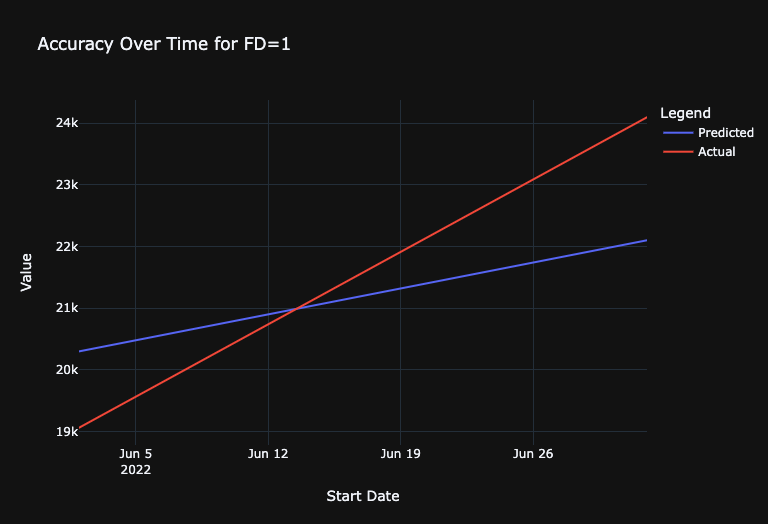

In [47]:
# Get Accuracy over Time for FD=6, For just Segment A
acc_plot_FD6_Consumer = top_model.get_accuracy_over_time_plot(
    backtest=0, forecast_distance=6, series_id="Segment A"
)

# Convert to dataframe
df = pd.DataFrame.from_dict(acc_plot_FD6_Consumer.bins)

# Plotly Graph
fig = go.Figure()

# Adding traces for "predicted" and "actual"
fig.add_trace(go.Scatter(x=df["start_date"], y=df["predicted"], mode="lines", name="Predicted"))
fig.add_trace(go.Scatter(x=df["start_date"], y=df["actual"], mode="lines", name="Actual"))

# Update layout for better visualization
fig.update_layout(
    title="Accuracy Over Time for FD=6 (Segment A)",
    xaxis_title="Start Date",
    yaxis_title="Value",
    legend_title="Legend",
    template="plotly_dark",
)

# Display the plot
fig.show()

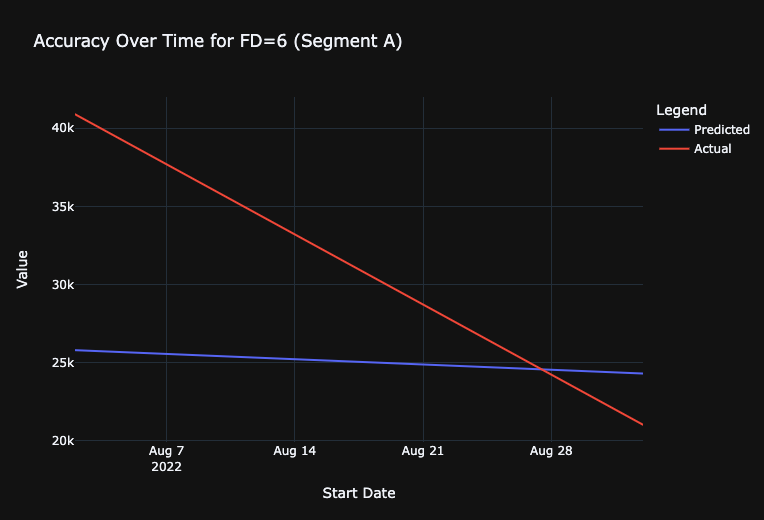

## Retrieve Feature Impact
As an example of model explainability, calculate the Feature Impact values of the model using the get_or_request_feature_impact function.

In [20]:
# get model
top_model = dr.Model.get(project=project.id, model_id=scores["Model_ID"][2])

# Request and retrieve feature impact
feature_impacts = (
    top_model.get_or_request_feature_impact()
)  # Will trigger Feature Impact calculations if not done
FI_df = pd.DataFrame(feature_impacts)  # Convert to dataframe

# Sort features by Normalized Feature Impact
FI_df = FI_df.sort_values(by="impactNormalized", ascending=False)

# Take top 10
FI_df = FI_df[0:5]

# Plotly Graph
fig = go.Figure()

# Add bar trace
fig.add_trace(go.Bar(y=FI_df["featureName"], x=FI_df["impactNormalized"], orientation="h"))

# Update layout for better visualization
fig.update_layout(
    title="Feature Impact",
    xaxis=dict(title="Normalized Feature Impact", range=[0, 1.1]),
    yaxis=dict(title="Feature", autorange="reversed"),
    margin=dict(l=200),  # this is to ensure the y-labels (feature names) are not cut off
    template="plotly_dark",
)

# Display the plot
fig.show()

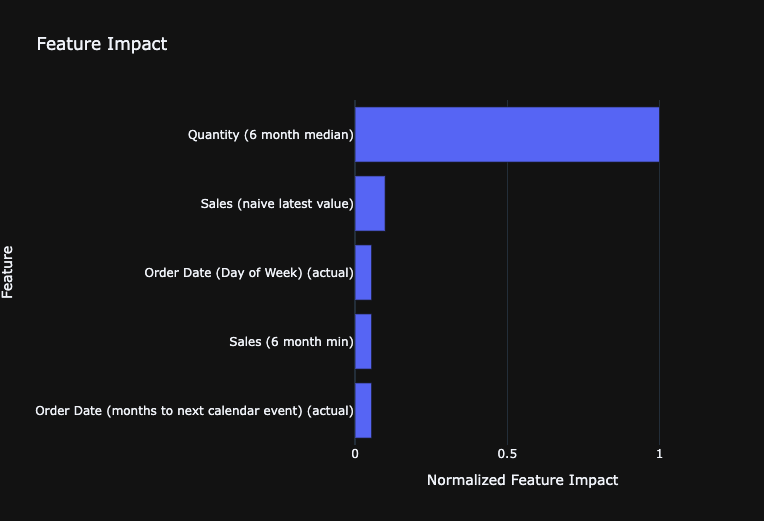

## Analyze Accuracy for each Series
The [Series Insight](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/series-insights-multi.html) tool provides the ability to compute the accuracy for each indivudal series. This is especially powerful to help us identify which series the model is doing particularly better or worse in forecasting.

In this demonstration, we see that the model has particularly high RMSE for the Savannah and Louisville store forecasts. We may consider refining our model by splitting those two series into a separate model as a future modeling experiment.

In [21]:
# Trigger the Series Insight computation
series_insight_job = top_model.compute_series_accuracy()
series_insight_job.wait_for_completion()  # Complete job before progressing

In [22]:
# Retrieve Series Accuracy
model_series_insight = top_model.get_series_accuracy_as_dataframe(
    metric="RMSE", order_by="backtestingScore"
)

# Unlist 'multiseriesValues' to 'Series' column
model_series_insight["multiseriesValues"] = model_series_insight["multiseriesValues"].apply(
    lambda x: x[0]
)
model_series_insight.rename(columns={"multiseriesValues": "Series"}, inplace=True)

# View
model_series_insight

,multiseriesId,Series,rowCount,duration,startDate,endDate,validationScore,backtestingScore,holdoutScore,targetAverage
0,659c873bbfbeaeb16bd40181,Segment C,48,P3Y11M0D,2019-01-01T00:00:00.000000Z,2022-12-01T00:00:00.000000Z,13365.29888,4402.537200,5592.83073,10741.328713
1,659c873bbfbeaeb16bd4017f,Segment A,48,P3Y11M0D,2019-01-01T00:00:00.000000Z,2022-12-01T00:00:00.000000Z,12213.31966,7665.218465,15377.09417,21776.275219
2,659c873bbfbeaeb16bd40180,Segment B,48,P3Y11M0D,2019-01-01T00:00:00.000000Z,2022-12-01T00:00:00.000000Z,10130.19989,8543.374845,24672.35535,22067.073963


In [23]:
# Create a scatter plot with Plotly
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=model_series_insight["Series"], y=model_series_insight["backtestingScore"], mode="markers"
    )
)

# Update the layout
fig.update_layout(
    title="Performance by Segment",
    xaxis=dict(title="Series", tickangle=45),
    yaxis=dict(title="RMSE"),
)

# Display the plot
fig.update_layout(template="plotly_dark")
fig.show()

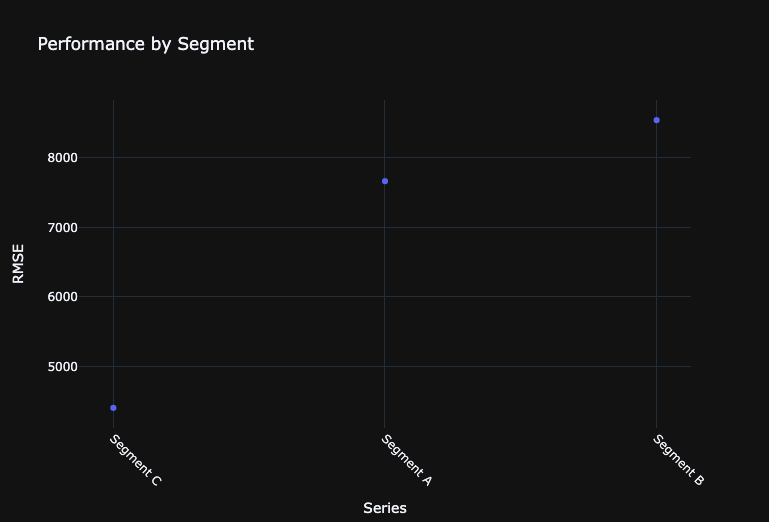

## Make new predictions with a test dataset
We can make new predictions directly on the leaderboard by uploading new test datasets to the project. We can then score the test dataset with any model on the leaderboard and retrieve the results.

In this notebook, we will load the data into the notebook and upload to the project. As with the training dataset, you can also use the JDBC connector to ingest the test dataset into the AI catalog and then directly use the dataset ID in the request_predictions call. The JDBC path provides more efficient upload of large datasets to DataRobot.

For time-series predictions, DataRobot expects new prediction datasets to have rows for each new date we want to forecast. These rows should have values for the known-in-advance features and NA everywhere else. For example, since the model is forecasting 1-7 days out from each forecast point, we will have 7 new rows (corresponding from June 15 to June 21, 2014).

In [24]:
# Upload data to modeling project
df = training_dataset.get_as_dataframe()
test_dataset = project.upload_dataset(df)

# Get frozen model
frozen_model = all_models[0]

# Request Predictions
pred_job = frozen_model.request_predictions(
    dataset_id=test_dataset.id, include_prediction_intervals=True, prediction_intervals_size=85
)

preds = pred_job.get_result_when_complete()

preds.head(5)

,row_id,prediction,forecast_distance,forecast_point,timestamp,series_id,prediction_interval_lower_bound,prediction_interval_upper_bound
0,144,34059.371646,1,2022-12-01T00:00:00.000000Z,2023-01-01T00:00:00.000000Z,Segment A,26322.563156,46154.145465
1,145,34059.371646,2,2022-12-01T00:00:00.000000Z,2023-02-01T00:00:00.000000Z,Segment A,25439.796512,46434.687658
2,146,34059.371646,3,2022-12-01T00:00:00.000000Z,2023-03-01T00:00:00.000000Z,Segment A,26978.561118,43444.787335
3,147,34059.371646,4,2022-12-01T00:00:00.000000Z,2023-04-01T00:00:00.000000Z,Segment A,24518.984770,46113.285919
4,148,34059.371646,5,2022-12-01T00:00:00.000000Z,2023-05-01T00:00:00.000000Z,Segment A,26594.813046,45538.589234


In [25]:
# Step 1: Rename columns in preds to match training_df
renamed_preds = preds.rename(
    columns={"prediction": "Sales", "timestamp": "Order Date", "series_id": "Segment"}
)

# Step 2: Drop columns from preds that are not in training_df
columns_to_keep = [
    "Segment",
    "Order Date",
    "Sales",
]  # Columns from preds that correspond to training_df
modified_preds = renamed_preds[columns_to_keep]

## Join Forecasts to Actuals

In [26]:
# Function to evaluate date time values


def convert_or_localize_to_utc(series):
    if series.dt.tz is not None:  # If it's already timezone-aware
        return series.dt.tz_convert("UTC")
    return series.dt.tz_localize("UTC")  # If it's naive, then localize it


# Convert or localize 'Order Date' in training_df to UTC
training_df["Order Date"] = pd.to_datetime(training_df["Order Date"])
training_df["Order Date"] = convert_or_localize_to_utc(training_df["Order Date"])

# Rename columns in prediction data
renamed_preds = preds.rename(
    columns={"prediction": "Sales", "timestamp": "Order Date", "series_id": "Segment"}
)

# Drop columns from prediction data that is not in training data
columns_to_keep = [
    "Segment",
    "Order Date",
    "Sales",
]  # Columns from preds that correspond to training_df
modified_preds = renamed_preds[columns_to_keep]

# Convert or localize 'Order Date' in preds_subset to UTC
preds_subset = modified_preds.copy()  # To avoid SettingWithCopyWarning
preds_subset["Order Date"] = pd.to_datetime(preds_subset["Order Date"])
preds_subset["Order Date"] = convert_or_localize_to_utc(preds_subset["Order Date"])

# Concatenate the DataFrames
combined_df = pd.concat([training_df, preds_subset], ignore_index=True)

# Sort by Segment and Order Date
combined_df.sort_values(by=["Segment", "Order Date"], inplace=True)

## Visualize Forecasts With a Line Chart

In [27]:
# Initialize the figure
fig = go.Figure()

# Define a color mapping for segments (you can extend or modify this as needed)
color_map = {"Segment A": "blue", "Segment B": "green", "Segment C": "orange"}

# For each segment, plot actual sales and forecasted sales
for segment, color in color_map.items():
    segment_df = combined_df[combined_df["Segment"] == segment]
    actuals = segment_df[:-12]  # Adjust based on your actual data
    forecast = segment_df[-12:]

    fig.add_trace(
        go.Scatter(
            x=actuals["Order Date"],
            y=actuals["Sales"],
            mode="lines",
            name=f"{segment} Actuals",
            line=dict(color=color),  # Use the color from the color_map
        )
    )

    fig.add_trace(
        go.Scatter(
            x=forecast["Order Date"],
            y=forecast["Sales"],
            mode="lines",
            name=f"{segment} Forecast",
            line=dict(
                dash="dot", color=color
            ),  # Use the color from the color_map and make the line dotted
        )
    )

fig.update_layout(
    title="Actual + Forecasted Sales by Segment",
    xaxis_title="Order Date",
    yaxis_title="Sales",
    legend_title="Segments",
    template="plotly_dark",
)

fig.show()

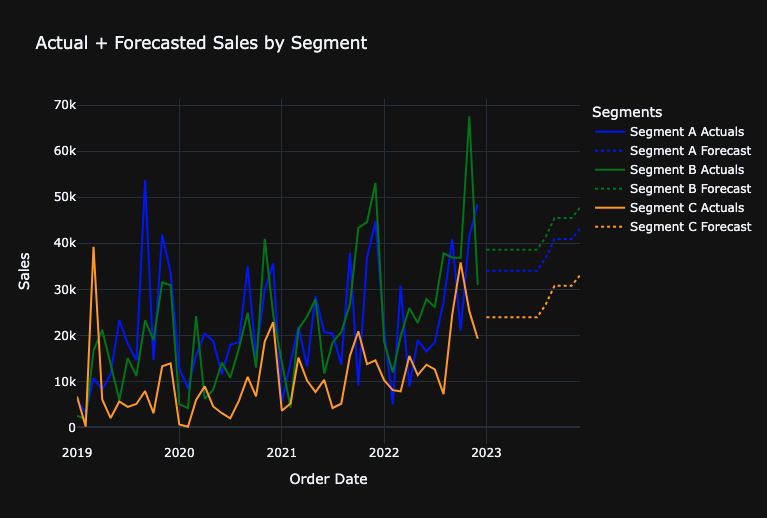

## Evaluate Forecasted Growth Metrics

FP&A teams typically use a variety of growth metrics to gain a comprehensive understanding of sales performance. Different metrics can provide unique insights into how a financial metrics is trending and what underlying factors might be driving those trends. 

1. **Month Over Month Growth (MoM Growth)**: evaluates the growth of sales (or any other metric) from one month to the next. MoM Growth can provide a short-term perspective on trends to quickly identify any sudden changes or spikes which might be due to seasonality, promotions, or other short-term factors. Useful for identifying short-term operational challenges or successes.

2. **Monthly Year Over Year Growth (YoY Growth)**: evaluates a specific month to the sales in the same month the previous year. This view accounts for seasonality, as it compares the same month across years and can helps identify longer-term trends and determine if a particular month's sales are genuinely growing or declining over the years.

3. **Year to Date Year over Year Growth (YTD YoY Growth)**: evaluates the cumulative sum from the beginning of the year up to a specific month as compared to the same time period in the previous year. This provides an aggregated view of performance over a year, making it easier to see if the company is on track to meet annual targets. This can also mitigate any month-to-month volatility, providing a more consistent perspective on how the year is progressing.

4. **Rolling 12 Month Year Over Year Growth (R12M YoY Growth)**: evaluates the most recent 12-month period to sales in the 12 months before that. This offers a continuously updated yearly perspective, irrespective of where you are in the calendar year and smoothens out short-term fluctuations and seasonality, as it always encompasses a full year of data.

### Calculate the forecasted year over year growth

In [28]:
def calculate_growth(segment_data):
    forecast_sum = segment_data.tail(12)["Sales"].sum()
    prior_year_sum = segment_data.iloc[-24:-12]["Sales"].sum()
    two_years_ago_sum = segment_data.iloc[-36:-24]["Sales"].sum()

    forecasted_growth = (forecast_sum - prior_year_sum) / prior_year_sum * 100
    prior_year_growth = (prior_year_sum - two_years_ago_sum) / two_years_ago_sum * 100

    return forecast_sum, prior_year_sum, forecasted_growth, prior_year_growth


segments = combined_df["Segment"].unique()
growth_data = [
    (*calculate_growth(combined_df[combined_df["Segment"] == segment]), segment)
    for segment in segments
]

growth_df = pd.DataFrame(
    growth_data,
    columns=[
        "Forecasted Total",
        "Prior Year Total",
        "Forecasted Growth",
        "Prior Year Growth",
        "Segment",
    ],
)

# Calculate aggregate level
aggregate_prior_year = growth_df["Prior Year Total"].sum()
aggregate_forecast = growth_df["Forecasted Total"].sum()
aggregate_growth = (aggregate_forecast - aggregate_prior_year) / aggregate_prior_year * 100

adjusted_prior_year_growth = (
    (
        aggregate_prior_year
        - growth_df["Prior Year Total"].sum()
        + growth_df.iloc[-1]["Prior Year Total"]
    )
    / (growth_df["Prior Year Total"].sum() - growth_df.iloc[-1]["Prior Year Total"])
    * 100
)

aggregate_row = pd.DataFrame(
    [
        {
            "Segment": "Total",
            "Prior Year Total": aggregate_prior_year,
            "Forecasted Total": aggregate_forecast,
            "Forecasted Growth": aggregate_growth,
            "Prior Year Growth": adjusted_prior_year_growth,
        }
    ]
)

growth_df = pd.concat([growth_df, aggregate_row], ignore_index=True)

## Visualize the year over year growth in a bar chart

In [29]:
def plot_sales_data_with_table(growth_df):
    # Filter out the 'Total' row for the bar chart
    chart_df = growth_df[growth_df["Segment"] != "Total"]

    # Create subplots: one row for bar chart, one row for table
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.15,
        subplot_titles=("Prior Year vs Forecasted Sales Totals by Segment", "Data Table"),
        row_heights=[0.7, 0.3],
        specs=[[{"type": "xy"}], [{"type": "table"}]],
    )

    # Add bar chart to the first row of subplot
    fig.add_trace(
        go.Bar(name="Prior Year Total", x=chart_df["Segment"], y=chart_df["Prior Year Total"]),
        row=1,
        col=1,
    )
    forecasted_total_bar = go.Bar(
        name="Forecasted Total", x=chart_df["Segment"], y=chart_df["Forecasted Total"]
    )
    fig.add_trace(forecasted_total_bar, row=1, col=1)

    # Overlay forecast growth on top of the Forecasted Total bars
    for i, segment in enumerate(chart_df["Segment"]):
        fig.add_annotation(
            x=segment,
            y=chart_df.loc[chart_df["Segment"] == segment, "Forecasted Total"].values[0],
            text=f"{chart_df.loc[chart_df['Segment'] == segment, 'Forecasted Growth'].values[0]:.2f}%",
            showarrow=False,
            font=dict(color="white"),
            row=1,
            col=1,
        )

    # Change the bar mode to 'group'
    fig.update_layout(barmode="group")

    # Specify the order of columns for the table
    ordered_columns = [
        "Segment",
        "Prior Year Total",
        "Forecasted Total",
        "Forecasted Growth",
        "Prior Year Growth",
    ]

    # Format the numeric values with commas and two decimal points
    formatted_data = []
    for col in ordered_columns:
        if growth_df[col].dtype in [float, "float64"]:
            # Format float columns
            formatted_data.append(growth_df[col].map("{:,.2f}".format).tolist())
        elif growth_df[col].dtype in [int, "int64"]:
            # Format integer columns
            formatted_data.append(growth_df[col].map("{:,}".format).tolist())
        else:
            # Keep non-numeric columns as is
            formatted_data.append(growth_df[col].tolist())

    table_header = ordered_columns

    fig.add_trace(
        go.Table(header=dict(values=table_header), cells=dict(values=formatted_data)), row=2, col=1
    )

    # Update layout
    fig.update_layout(template="plotly_dark")

    fig.show()


# Example usage with your growth_df dataframe
plot_sales_data_with_table(growth_df)

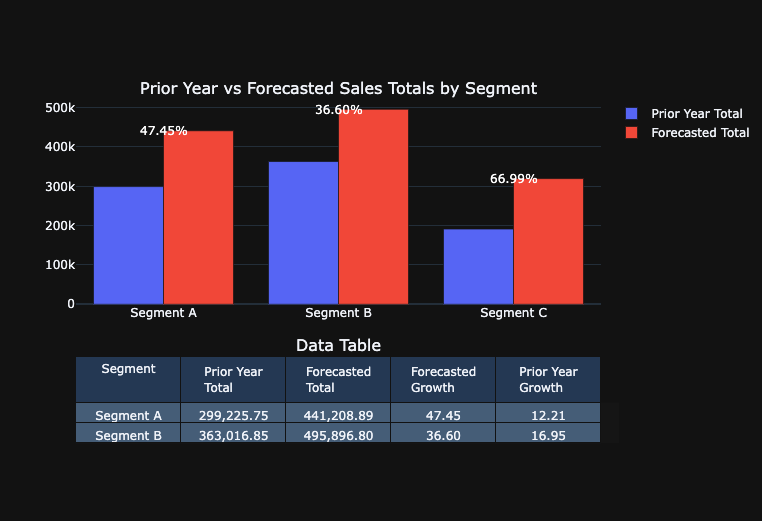

## Calculate additional metrics to evaluate forecasted growth

In [30]:
# Create a copy of training_df with only the necessary columns
df_copy = combined_df[["Segment", "Order Date", "Sales"]].copy()

# Convert "Order Date" column of df_copy to datetime and set as index
df_copy["Order Date"] = pd.to_datetime(df_copy["Order Date"])
df_copy.set_index("Order Date", inplace=True)


def calculate_growth_metrics(segment_data):
    # Using .loc to set values to avoid SettingWithCopyWarning
    segment_data = segment_data.copy()
    segment_data.loc[:, "Year"] = segment_data.index.year
    segment_data.loc[:, "Month"] = segment_data.index.month

    # Group by year and month to get monthly sales and specify numeric_only=True
    monthly_sales = segment_data.groupby(["Year", "Month"]).sum(numeric_only=True)

    # Calculate growth metrics
    monthly_sales["MoM Growth"] = monthly_sales["Sales"].pct_change() * 100
    monthly_sales["Monthly YoY Growth"] = monthly_sales["Sales"].pct_change(periods=12) * 100
    monthly_sales["Rolling 12 Mth YoY Growth"] = (
        monthly_sales["Sales"].rolling(window=12).sum().pct_change(periods=12) * 100
    )

    # New YTD Growth logic
    monthly_sales["YTD"] = monthly_sales["Sales"].groupby(level=0).cumsum()
    previous_ytd = monthly_sales["YTD"].shift(12)
    monthly_sales["YTD YoY Growth"] = ((monthly_sales["YTD"] - previous_ytd) / previous_ytd) * 100

    # Convert 'Year' and 'Month' back to actual date (the first day of each month)
    monthly_sales.reset_index(inplace=True)
    monthly_sales["Order Date"] = pd.to_datetime(monthly_sales[["Year", "Month"]].assign(DAY=1))
    monthly_sales.drop(["Year", "Month"], axis=1, inplace=True)

    return monthly_sales


# Filter data based on segments and calculate metrics
segmenta_df = calculate_growth_metrics(df_copy[df_copy["Segment"] == "Segment A"])
segmentb_df = calculate_growth_metrics(df_copy[df_copy["Segment"] == "Segment B"])
segmentc_df = calculate_growth_metrics(df_copy[df_copy["Segment"] == "Segment C"])
total_df = calculate_growth_metrics(df_copy[df_copy["Segment"] == "Total"])

## Visualize the additional metrics with line charts

In [49]:
# Function to plot a specific growth metric for all segments and show table below


def plot_metric_across_segments_with_table(metric_name, datasets, yaxis_range=None):
    # Create subplots: one row for line chart, one row for table
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=(f"Comparison of {metric_name} Across Segments", "Data Table"),
        row_heights=[0.7, 0.3],
        specs=[[{"type": "xy"}], [{"type": "table"}]],
    )

    # Lists to store filtered data for the table
    table_dates = None
    table_metric_values = []

    # Add line plots to the first row of subplot
    for segment_name, segment_df in datasets.items():
        # Filter DataFrame to remove null values in the metric column and keep data from January 2014 onwards
        segment_df = segment_df[
            pd.notnull(segment_df[metric_name]) & (segment_df["Order Date"] >= "2014-01-01")
        ]

        # Store filtered data for table
        if table_dates is None:
            table_dates = segment_df["Order Date"].tolist()

        # Format metric values to two decimal points
        formatted_metric_values = [round(val, 2) for val in segment_df[metric_name].tolist()]
        table_metric_values.append(formatted_metric_values)

        fig.add_trace(
            go.Scatter(
                x=segment_df["Order Date"],
                y=segment_df[metric_name],
                mode="lines",
                name=segment_name,
            ),
            row=1,
            col=1,
        )

    # Create a table with the filtered data
    table_data = [table_dates] + table_metric_values
    table_header = ["Order Date"] + list(datasets.keys())

    fig.add_trace(
        go.Table(header=dict(values=table_header), cells=dict(values=table_data)), row=2, col=1
    )

    # Update layout
    fig.update_layout(template="plotly_dark", yaxis_range=yaxis_range)

    fig.show()


# Datasets for all segments
datasets = {
    "Segment A": segmenta_df,
    "Segment B": segmentb_df,
    "Segment C": segmentc_df,
    "Total": total_df,
}

# Create the plots for each specific metric:
plot_metric_across_segments_with_table("MoM Growth", datasets, yaxis_range=[-200, 500])
plot_metric_across_segments_with_table("Monthly YoY Growth", datasets, yaxis_range=[-200, 600])
plot_metric_across_segments_with_table("YTD YoY Growth", datasets, yaxis_range=[-200, 300])
plot_metric_across_segments_with_table("Rolling 12 Mth YoY Growth", datasets)

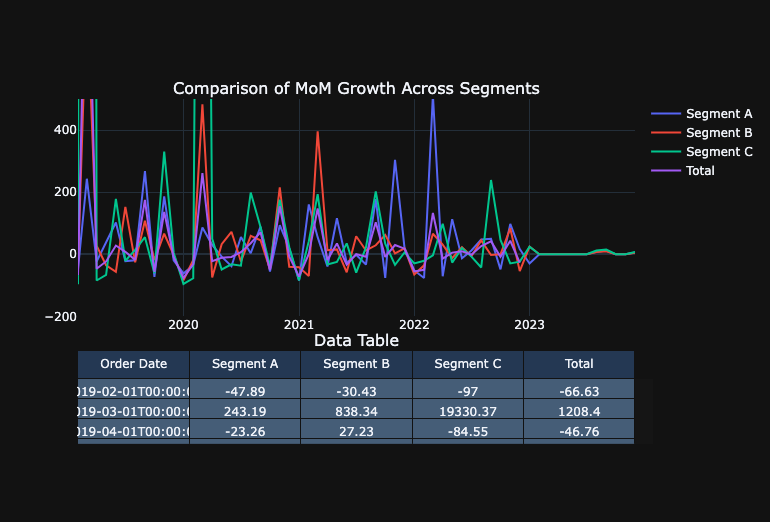

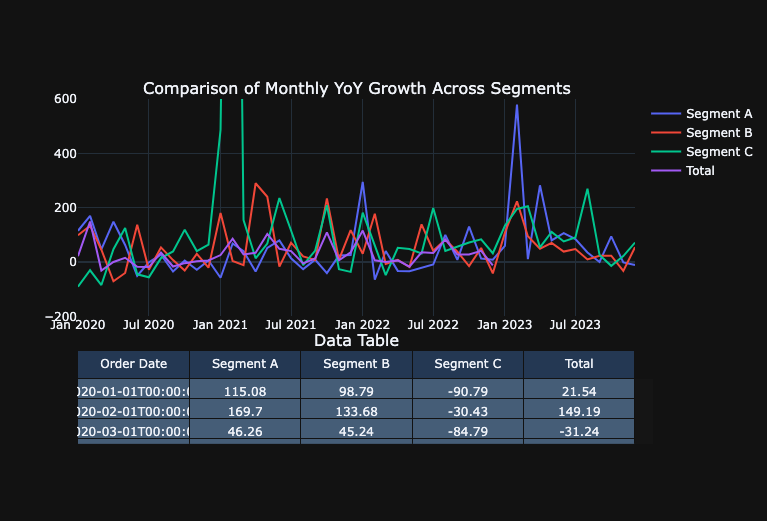

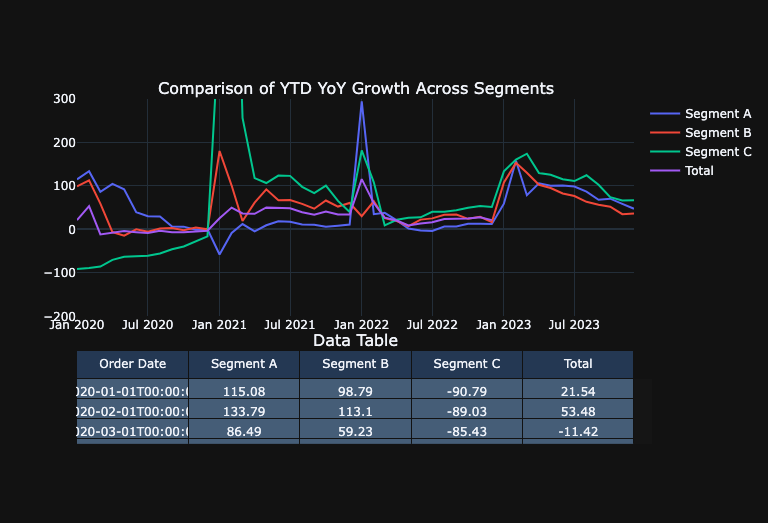

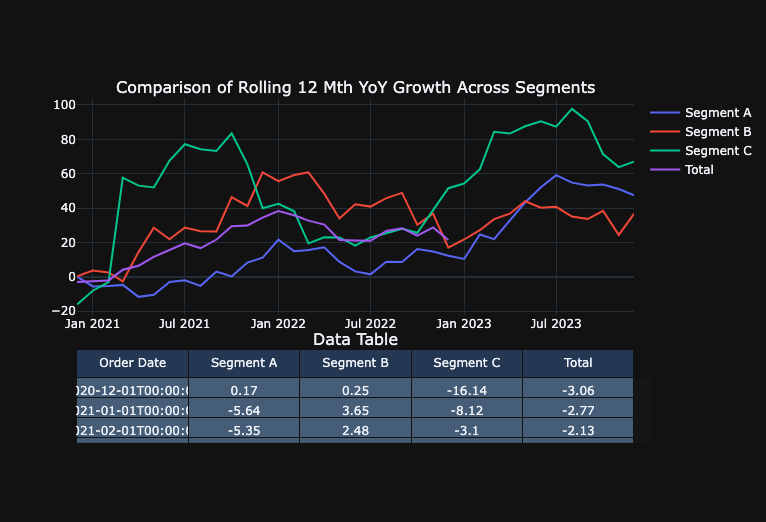

## Deploy Model to DataRobot ML Production for Monitoring and Governance

In [32]:
# Set the prediction server to deploy to
prediction_server_id = dr.PredictionServer.list()[
    0
].id  # EDIT THIS BASED ON THE PREDICTION SERVERS AVAILABLE TO YOU

# Set deployment details
deployment = dr.Deployment.create_from_learning_model(
    model_id=frozen_model.id,
    label="FP&A - Segment Forecasting Model",
    description="FP&A - Segment Forecasting Model",
    default_prediction_server_id=prediction_server_id,
)

## Request Predictions from Deployment

In [33]:
# Score the dataset using the given deployment ID
job, predictions = dr.BatchPredictionJob.score_pandas(
    deployment.id, df
)  # Deployment ID and Scoring dataset

# Print a message to indicate that scoring has started
print("Started scoring...", job)

# Wait for the job to complete
job.wait_for_completion()

Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 659c8b967ac471a283a743a2
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.
Started scoring... BatchPredictionJob(batchPredictions, '659c8b967ac471a283a743a2', status=INITIALIZING)


## Clean Up

In [34]:
# # CLEAN UP - Uncomment and run this cell to remove everything you added during this session
deployment.delete()
# project.delete()

# Next Steps and Additional Resources

## Improve Accuracy

There are a number of approaches that we could apply to improve model accuracy. We can try:


-  Running DataRobot's entire blueprint repository
-  Evaluating different feature derivation windows across projects
-  Evaluating different training lengths
-  Evaluating different blenders / ensemble models
-  Adding in additional data or other data sources (e.g. macroeconomic data)

## Other Use Cases
- [Scenario analysis](https://docs.datarobot.com/en/docs/app-builder/ts-app.html#what-if-widget) - evaluate what happens to our sales forecasts under certain conditions by leveraging [known in advance variables](https://docs.datarobot.com/en/docs/modeling/build-models/adv-opt/time-series-adv-opt.html#set-known-in-advance-ka) in DataRobot
- Long term strategic planning where we can forecast over longer time horizons than annual planning requires.
- Risk management - model potential risks that have financial impacts, such as: churn, write-downs, etc.

## Additional Resources
- [The DataRobot AI Accelerator Library](https://community.datarobot.com/t5/ai-accelerators-library/tkb-p/ai-accelerators-library) has similar accelerators for other [Ecosystem Integrations](https://community.datarobot.com/t5/ai-accelerators-library/tkb-p/ai-accelerators-library/label-name/ecosystem%20integration%20templates) to use DataRobot with other tools (e.g. AWS, GCP, Azure, etc) as well as accelerators for more advanced time-series applications.
- [The DataRobot API user guide](https://docs.datarobot.com/en/docs/api/guide/python/index.html) provides code examples covering topics such as model factories, classification problems, feature impact rank ensembling, and more.

To learn more about advanced workflows for handling complex and large scale time series problems:

- [Time series clustering](https://docs.datarobot.com/en/docs/modeling/time/ts-clustering.html#time-series-clustering)
- [Segmented modeling](https://docs.datarobot.com/en/docs/modeling/time/ts-segmented.html)